In [1]:
import os
import pandas as pd
import dask.dataframe as dd
import numpy as np
import seaborn as sns

In [2]:
Analise_INDICE = True

In [3]:
mainpath = 'C:/Users/david/OneDrive/Documents/FERV_documentos/RESULTS'
dic_cenarios = {
                # 'MPA FNS Lim Scenario 2022' : f'{mainpath}/MPV_(FNS Lim)_RC/',
                # 'V1A1F2 2026' :f'{mainpath}/V1A1F2_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F2 2026' :f'{mainpath}/V1A1F2_RESP_FNS_lim_rev2_2026/',
                # 'V1A1F3 2026' :f'{mainpath}/V1A1F3_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F4 2026' :f'{mainpath}/V1A1F4_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F5 2026' :f'{mainpath}/V1A1F5_RESP_FNS_lim_rev1_2026/',

                'V1A1F2' :f'{mainpath}/V1A1F2_rev5/',
                # 'V1A1F3' :f'{mainpath}/V1A1F3_rev5/',
                # 'V1A1F4' :f'{mainpath}/V1A1F4_rev5/',
                # 'V1A1F5' :f'{mainpath}/V1A1F5_rev5/',

                # 'V2A2F2' :f'{mainpath}/V2A2F2_rev5/', 
                # 'V2A2F3' :f'{mainpath}/V2A2F3_rev5/',
                # 'V2A2F4' :f'{mainpath}/V2A2F4_rev5/', 
                # 'V2A2F5' :f'{mainpath}/V2A2F5_rev5/',

                # 'V3A3F2' :f'{mainpath}/V3A3F2_rev5/',
                # 'V3A3F3' :f'{mainpath}/V3A3F3_rev5/',
                # 'V3A3F4' :f'{mainpath}/V3A3F4_rev5/', 
                # 'V3A3F5' :f'{mainpath}/V3A3F5_rev5/',
                }

dirGeral = 'StaticAnalysis/Data/Geral/'
# dirIndice = 'StaticAnalysis/Data/Indice_n_supremo/'
dirIndice = 'StaticAnalysis/Data/Indice_n_2/'
dirRamos = 'StaticAnalysis/Data/Fluxo em Ramos/'
dirPotencia = 'StaticAnalysis/Data/Potencia/'

filenames = [
                (dirGeral + 'OPF_NC.csv', 'OPF_NC'), 
                (dirGeral + 'PWF_NC.csv', 'PWF_NC'),
                (dirGeral + 'Df_ger.csv', 'ger'), 
                (dirGeral + 'Df_nt.csv', 'nt'), 
                (dirRamos + 'Df_Linhas.csv', 'linhas'), 
                (dirRamos + 'Df_Trafo.csv', 'Trafo'), 
                (dirRamos + 'DF_Intercambios.csv', 'intercambios'), 
                (dirRamos + 'DF_HVDC.csv', 'HVDC'),
                (dirPotencia +'Df_Reserva_PO_MW.csv', 'pot_mw_reserv'),  
                # (dirIndice + 'Df_DPI_S2.csv', 'Index'), 
                (dirIndice +'Df_DPI_S4.csv', 'Index_PO'),  #deixar esse descomentado para poder filtrar os não convergidos
                # (dirIndice + 'Df_DPI_S3.csv', 'Index_Modif'), 
                # (dirIndice +'Df_PQ_DPI_S1.csv', 'IndexDec_PQ'), 
                # (dirIndice +'Df_PV_DPI_S1.csv', 'IndexDec_PV'), 
                (dirPotencia+'Df_MW-MVAR_PO.csv', 'pot_mw_mvar'), 
                (dirPotencia+'DF_POT_Reg.csv', 'ger_reg'),
                # (dirRamos+'Df_AreasInfo.csv', 'areas'),
            ]
import colorcet as cc
intense_palette = sns.color_palette(cc.glasbey, n_colors=12)  # You can adjust the number of colors as needed
namescenarios = {key:[key,intense_palette[idx]] for idx, key in enumerate(dic_cenarios.keys())}
itemsforanalysis = [var for _,var in filenames]

## Processamento de dados

In [4]:
# Optimized read_and_append function using Dask
def read_and_append(filename, cenario, lst):
    df = dd.read_csv(filename)  # Keep as Dask DataFrame for now
    df['Cenario'] = cenario
    # Avoid converting to pandas immediately; do this after processing
    lst.append(df)
    return lst

# Function to load and process all datasets
def load_and_process_data(dic_cenarios, filenames):
    keys = [i for _, i in filenames]
    dfs = {key: [] for key in keys}

    # Read and append data from each scenario and filename
    for cenario, path in dic_cenarios.items():
        for filename, key in filenames:
            dfs[key] = read_and_append(path + filename, cenario, dfs[key])

    # Convert all dask DataFrames to pandas after appending
    dfs = {key: dd.concat(lst).compute() for key, lst in dfs.items()}
    
    return dfs

# Function to calculate indices for lines
def IndiceLinhas(df, n):

    df['MW_Flow'] = np.where(df['MW:From-To'] >= 0, df['MW:From-To'], df['MW:To-From'])
    df['PI_mva'] = (df['% L1'] / 100) ** (2 * n)

    # Group by multiple columns and aggregate
    df_r_nt_1 = df[df['VBASEKV']>=500].groupby(
        ['key', 'Cenario', 'REG']
    ).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})

    df_r_nt_2 = df[df['VBASEKV']<500].groupby(
        ['key', 'Cenario', 'REG']
    ).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})

    df_r_nt_1['PI_mva_500up'] = df_r_nt_1['PI_mva'] ** (1 / (2 * n))
    df_r_nt_2['PI_mva_500down'] = df_r_nt_2['PI_mva'] ** (1 / (2 * n))

    df_r_nt = df_r_nt_1[['PI_mva_500up']].merge(df_r_nt_2[['PI_mva_500down']], on=['key', 'Cenario', 'REG'], how='outer')
    df_r_nt.fillna({'PI_mva_500up': 0, 'PI_mva_500down': 0,}, inplace=True)

    return df_r_nt

# Function to flatten DataFrame
def flatdf(df, BG):
    df_reordered = df.reorder_levels(['key','Dia', 'Hora', 'Cenario', 'REG', BG])
    regionmap = {
        'Nordeste': 'Northeast', 'Norte': 'North', 'Sudeste-Centro-Oeste': 'SE-CW',
        'Sul': 'South', 'AC-RO': 'AC-RO'
    }
    df_reordered = df_reordered.rename(index=regionmap, level='REG')
    df_reordered_sorted = df_reordered.sort_index(level=['key','Dia', 'Hora', 'Cenario', 'REG'])
    df_reordered_sorted.rename(columns={'CSI_INF': 'DPI_inf', 'CSI_SUP': 'DPI_sup'}, inplace=True)

    lista = [[index[0], index[1], index[2], index[3]] for index in df_reordered.index]
    conjunto_filtros = set(map(tuple, lista))
    conjunto_filtros = tuple(sorted(conjunto_filtros))

    data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
    datapd = pd.DataFrame(data, index=conjunto_filtros)
    datapd.index.names = ['key','Dia', 'Hora', 'Cenario']
    
    columns = []
    for reg in df_reordered_sorted.reset_index('REG')['REG'].unique():
        for bg in df_reordered_sorted.loc[:, :, :, : ,reg, :].reset_index(BG)[BG].unique():
            for column in df_reordered_sorted.columns:
                reg_name = 'SE-CO' if reg == 'Sudeste-Centro-Oeste' else reg
                columns.append(f"{column}_{reg_name}_{bg}")

    datapd.columns = columns
    return datapd

# Function to read data
def read_data():
    def read_and_append(filename, cenario, lst):
        df = dd.read_csv(filename)
        df['Cenario'] = cenario
        # if cenario == 'V1A1F2 Scenario 2022 FNS':
        #     df['Dia'] = df['Dia'] - 1
        lst.append(df.compute())
        return lst

    keys = [i for _,i in filenames]
    dfs = {}
    for key in keys:
        dfs[key] = []
    for i,j in  dic_cenarios.items():
        for filename, key in filenames:
            dfs[key] = read_and_append(j + filename, i, dfs[key])

    return dfs



# Function to filter data based on non-convergent conditions
def filtarNC(df, dfconv):
    mask_PWFCV = dfconv.reset_index()[['key', 'Cenario']]
    df_out = df.reset_index().merge(mask_PWFCV, on=['key', 'Cenario'], how='inner')
    
    return df_out

In [5]:
# Function to concatenate and process data (part 1)
def concatenation_1(data):
    

    data['df_ger_reg_concat'] = filtarNC(data['ger_reg'], data['Index_PO'])
   
    if all(keyword in itemsforanalysis for keyword in ['linhas', 'Trafo', 'intercambios', 'HVDC', 'pot_mw_reserv']):

        # print('====== Selecting Critical Lines as features ======')
        data['linhas']['L1(MVA)'] = data['linhas']['L1(MVA)'].astype('float32')
        data['linhas']['VBASEKV'] = data['linhas']['VBASEKV'].astype('int16')  # if appropriate for your data

        data['linhas'] = data['linhas'].loc[(data['linhas']['L1(MVA)'] != 9999) & (data['linhas']['VBASEKV'].isin([230, 345, 440, 500, 525, 765]))]
        data['PI_mva'] = IndiceLinhas(data['linhas'], 1)  #para calcular o MWFLOW

        # data['features_lines'] = computefeatures_2(data['linhas'], data['PI_mva'].reset_index())
        data['Trafo'] = data['Trafo'].loc[(data['Trafo']['L1(MVA)'] != 9999) & (data['Trafo']['VBASEKV'].isin([230, 345, 440, 500, 525, 765]))]
        data['Trafo'] = data['Trafo'].rename(columns={'% L1': '% L1_Trafo', 'Mvar:Losses': 'Mvar:Losses_Trafo'})
        data['pot_mw_reserv'] = data['pot_mw_reserv'].set_index(['Dia', 'Hora', 'Cenario'])

        df_intercambios_01 = data['intercambios'].rename(columns={'Intercambio AC': 'Intercambio'}).set_index(['key','Dia', 'Hora', 'Cenario', 'Intercambio'])
        df_hvdc_01 = data['HVDC'].rename(columns={'Nome Elo':'Intercambio', ' P(MW)': 'MW:From-To', ' Q(Mvar)': 'Mvar:From-To'}).set_index(['key','Dia', 'Hora', 'Cenario', 'Intercambio'])

        concatenated_HVDC = pd.concat([
                df_hvdc_01.loc[:,:, :, :, 'Elo_FOZ-IBIUNA']['MW:From-To'],
                df_hvdc_01.loc[:,:, :, :, 'Elo_PVEL-ARARQ']['MW:From-To'],
                df_hvdc_01.loc[:,:, :, :, 'Elo_XINGU-SE']['MW:From-To'],
                # df_hvdc_01.loc[:,:, :, :, 'Elo_CPVBTB-PVEL']['MW:From-To']
                ], axis=1, keys=['Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_XINGU-SE'])

        concatenated_FluxoAC = pd.concat([
                df_intercambios_01.loc[:,:, :, :, 'EXP_NE']['MW:From-To'],
                df_intercambios_01.loc[:,:, :, :, 'Fluxo_NE-N']['MW:From-To'],
                df_intercambios_01.loc[:,:, :, :, 'Fluxo_NE-SE']['MW:From-To'], 
                df_intercambios_01.loc[:,:, :, :, 'Fluxo_N-S']['MW:From-To'],
                df_intercambios_01.loc[:,:, :, :, 'Fluxo_SUL-SECO']['MW:From-To']

                ], axis=1, keys=['EXP_NE', 'Fluxo_NE-N', 'Fluxo_NE-SE', 'Fluxo_N-S','Fluxo_SUL-SECO'])

        data['df_Inter_AC_DC'] = concatenated_HVDC.merge(concatenated_FluxoAC, on=['key','Dia', 'Hora', 'Cenario'], how='left')

    return data

# Function to concatenate and process data (part 2)
def concatenation_2(data):

    print('====== Second Concatenation ======')

    Jirau = [7051, 7061]
    S_Antonio = [7050, 7062, 7064]
    G_Uhe_230_ACRO = [6888, 6892, 6891]
    Tucurui = [6419, 6420, 6422, 6424, 6425]
    B_Monte = [6729]
    Itaipu_50 = [1100]
    Itaipu_60 = [1107]
    I_Solt = [501]
    AngraI = [10]
    AngraII = [11]
    TPires = [4492]
    S_Mesa = [36]
    XINGO = [5061]
    Furnas = [16]

    DF_complete_PO = data['df_ger_reg_concat'].drop(columns=['REG', 'PG_FERV']).groupby(by=['key','Dia', 'Hora', 'Cenario']).sum(numeric_only=True)
    DF_complete_PO['PG_FERV'] = (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL']) / DF_complete_PO['PL_MW']
    DF_complete_PO['DL_MW'] = DF_complete_PO['PL_MW'] - (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL'])
    
    if 'ger' in itemsforanalysis:
        Df_ger = data['ger']

        Df_ger = Df_ger[Df_ger['BUS_ID'].isin(Jirau + S_Antonio + Tucurui + B_Monte + Itaipu_50 + Itaipu_60 + I_Solt + G_Uhe_230_ACRO+AngraI+AngraII+TPires+S_Mesa+XINGO+Furnas)]
        DF_complete_PO[['Jirau_MW', 'Jirau_MVAR', 'Jirau_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Jirau)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['S_Antonio_MW', 'S_Antonio_MVAR', 'S_Antonio_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(S_Antonio)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['Tucurui_MW', 'Tucurui_MVAR', 'Tucurui_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Tucurui)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve',]].sum()
        DF_complete_PO[['B_Monte_MW', 'B_Monte_MVAR', 'B_Monte_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(B_Monte)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['Itaipu_50_MW', 'Itaipu_50_MVAR', 'Itaipu_50_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Itaipu_50)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['Itaipu_60_MW', 'Itaipu_60_MVAR', 'Itaipu_60_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Itaipu_60)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['I_Solt_MW', 'I_Solt_MVAR', 'I_Solt_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(I_Solt)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['G_ACRO_230_MW', 'G_ACRO_230_MVAR', 'G_ACRO_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(G_Uhe_230_ACRO)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['AngraI_MW', 'AngraI_MVAR', 'AngraI_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(AngraI)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['AngraII_MW', 'AngraII_MVAR', 'AngraII_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(AngraII)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['TPires_MW', 'TPires_MVAR', 'TPires_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(TPires)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['S_Mesa_MW', 'S_Mesa_MVAR', 'S_Mesa_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(S_Mesa)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['XINGO_MW', 'XINGO_MVAR', 'XINGO_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(XINGO)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['Furnas_MW', 'Furnas_MVAR', 'Furnas_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Furnas)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()

    return DF_complete_PO

# Function to concatenate and process data (part 3)
def concatenation_3(data):
    print('====== Third Concatenation ======')
    DFF_POT_REG = data['df_ger_reg_concat'].set_index(['Dia', 'Hora', 'REG', 'Cenario']).drop(columns='PG_FERV')
    
    if all(keyword in itemsforanalysis for keyword in ['linhas', 'Trafo', 'intercambios', 'HVDC', 'pot_mw_reserv']):

        df_linhas_500up_grouped = data['linhas'][data['linhas']['VBASEKV']>=500].groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum','MW:Losses': 'sum'}).rename(columns={'% L1': '% L1_500up', 'Mvar:Losses': 'Mvar:Losses_500up', 'MW:Losses': 'MW:Losses_500up'})

        df_linhas_500down_grouped = data['linhas'][data['linhas']['VBASEKV']<500].groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum','MW:Losses': 'sum'}).rename(columns={'% L1': '% L1_500down', 'Mvar:Losses': 'Mvar:Losses_500down', 'MW:Losses': 'MW:Losses_500down'})

        df_linhas_grouped_REG = pd.concat([df_linhas_500up_grouped, df_linhas_500down_grouped], axis=1)

        df_Trafo_grouped_REG = data['Trafo'].groupby(by=['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1_Trafo': 'mean', 'Mvar:Losses_Trafo': 'sum'})
        DF_complete_PO_REG = df_linhas_grouped_REG.merge(df_Trafo_grouped_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
        DF_complete_PO_REG = DF_complete_PO_REG.merge(DFF_POT_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    else:
        DF_complete_PO_REG = DFF_POT_REG

    if all(keyword in itemsforanalysis for keyword in ['IndexDec_PV', 'IndexDec_PQ', 'Index_Modif', 'Index']):

        df_Indice_REG_PV = data['df_Indice_REG'].loc['DPI_PV']
        df_Indice_REG_PQ = data['df_Indice_REG'].loc['DPI_PQ']
        df_REG_Cenario_PV = df_Indice_REG_PV.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
        df_REG_Cenario_PQ = df_Indice_REG_PQ.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')

        Df_data_completo_reg = df_REG_Cenario_PQ[['OV DPI', 'UV DPI']].merge(df_REG_Cenario_PV, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
        Df_data_completo_reg.rename(columns={'OV DPI_x': 'OV DPI_PQ', 'UV DPI_x': 'UV DPI_PQ', 'OV DPI_y': 'OV DPI_PV', 'UV DPI_y': 'UV DPI_PV'}, inplace=True)
    else:
        Df_data_completo_reg = DF_complete_PO_REG

    if all(keyword in itemsforanalysis for keyword in ['linhas', 'Trafo', 'intercambios', 'HVDC', 'pot_mw_reserv']):
        Df_data_completo_reg.fillna({'Mvar:Losses_500up': 0, '% L1_500up': 0, 'Mvar:Losses_500down': 0, '% L1_500down': 0, 'MW:Losses_500down':0, 'MW:Losses_500down':0}, inplace=True)

    return Df_data_completo_reg

# Main code execution
if __name__ == '__main__':

    print("Loading and processing data...")
    DATA = load_and_process_data(dic_cenarios, filenames)
    print("Data loaded and processed.")

    # # df_indice_grop = pd.concat(DATA['Index_PO'], axis=0)
    
    print('Concatenating data...')
    DATA = concatenation_1(DATA)
    DF_complete_PO = concatenation_2(DATA)
    Df_data_completo_reg = concatenation_3(DATA)
    
    # Renaming regions
    regionmap = {
        'Nordeste': 'Nordeste', 'Norte': 'Norte', 'Sudeste-Centro-Oeste': 'SE-CO',
        'Sul': 'Sul', 'AC-RO': 'AC-RO'
                }
    Df_data_completo_reg = Df_data_completo_reg.rename(index=regionmap, level='REG')
    
    if 'ger' in itemsforanalysis:
        DATA['ger']['REG']  = DATA['ger']['REG'].map(regionmap) # Faster replacement without resetting index
        DATA['nt']['REG']  = DATA['nt']['REG'].map(regionmap)    # Same for df_nt
        DATA['ger']['ARE']  = DATA['ger']['ARE'].astype(int) 
        DATA['nt']['ARE']  = DATA['nt']['ARE'].astype(int)
        DATA['ger']['Clase'] = 'Barras PV'   
        DATA['nt']['Clase'] = 'Barras PQ'   

Loading and processing data...
Data loaded and processed.
Concatenating data...
====== Second Concatenation ======
====== Third Concatenation ======


In [6]:
def optimize_dataframe_dtypes(df, verbose=True, exclude_cols=None, groupby_cols=None, dtypes_dict=None):
    """
    Optimize the data types of a pandas DataFrame to reduce memory usage,
    while considering columns required for specific operations.

    Parameters:
    - df: pandas DataFrame to optimize.
    - verbose: If True, prints memory usage information.
    - exclude_cols: List of column names to exclude from optimization.
    - groupby_cols: List of column names used in grouping operations.
    - dtypes_dict: Dictionary specifying desired data types for specific columns.

    Returns:
    - df_optimized: Optimized pandas DataFrame.
    """
    df_optimized = df.copy()
    initial_memory = df_optimized.memory_usage(deep=True).sum() / 1024**2  # in MB

    if exclude_cols is None:
        exclude_cols = []

    if groupby_cols is None:
        groupby_cols = []

    if dtypes_dict is None:
        dtypes_dict = {}

    for col in df_optimized.columns:
        col_type = df_optimized[col].dtypes

        if col in exclude_cols:
            if verbose:
                print(f"Excluding column: {col}")
            continue  # Skip columns that should not be optimized

        if col in dtypes_dict:
            # Convert to the specified data type
            df_optimized[col] = df_optimized[col].astype(dtypes_dict[col])
            if verbose:
                print(f"Converted {col} to {dtypes_dict[col]}")
            continue

        if verbose:
            print(f"Optimizing column: {col} (type: {col_type})")

        if col_type == object or col_type.name == 'string':
            num_unique_values = df_optimized[col].nunique(dropna=False)
            num_total_values = len(df_optimized[col])

            # Avoid converting grouping columns to 'category'
            if (num_unique_values / num_total_values < 0.5) and (col not in groupby_cols):
                df_optimized[col] = df_optimized[col].astype('category')
                if verbose:
                    print(f"Converted {col} to 'category' dtype.")
            else:
                # If the column contains dates, convert to datetime
                try:
                    df_optimized[col] = pd.to_datetime(df_optimized[col], errors='raise')
                    if verbose:
                        print(f"Converted {col} to 'datetime' dtype.")
                except (ValueError, TypeError):
                    pass  # Keep as object or consider converting to string type if appropriate

        elif pd.api.types.is_integer_dtype(col_type):
            # Avoid downcasting grouping columns to unsupported integer types
            if col in groupby_cols:
                if verbose:
                    print(f"Skipping downcasting for grouping column: {col}")
                continue

            c_min = df_optimized[col].min()
            c_max = df_optimized[col].max()
            if c_min >= 0:
                if c_max <= np.iinfo(np.uint8).max:
                    df_optimized[col] = df_optimized[col].astype(np.uint8)
                elif c_max <= np.iinfo(np.uint16).max:
                    df_optimized[col] = df_optimized[col].astype(np.uint16)
                elif c_max <= np.iinfo(np.uint32).max:
                    df_optimized[col] = df_optimized[col].astype(np.uint32)
                else:
                    df_optimized[col] = df_optimized[col].astype(np.uint64)
            else:
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df_optimized[col] = df_optimized[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df_optimized[col] = df_optimized[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df_optimized[col] = df_optimized[col].astype(np.int32)
                else:
                    df_optimized[col] = df_optimized[col].astype(np.int64)
            if verbose:
                print(f"Downcasted {col} to {df_optimized[col].dtype}")

        elif pd.api.types.is_float_dtype(col_type):
            # Avoid downcasting grouping columns to float16
            if col in groupby_cols:
                if verbose:
                    print(f"Skipping downcasting for grouping column: {col}")
                continue

            c_min = df_optimized[col].min()
            c_max = df_optimized[col].max()
            if np.finfo(np.float32).min < c_min and c_max < np.finfo(np.float32).max:
                df_optimized[col] = df_optimized[col].astype(np.float32)
                if verbose:
                    print(f"Downcasted {col} to {df_optimized[col].dtype}")
            else:
                df_optimized[col] = df_optimized[col].astype(np.float64)
                if verbose:
                    print(f"Kept {col} as {df_optimized[col].dtype}")

        elif pd.api.types.is_bool_dtype(col_type):
            # Ensure it's using the 'bool' dtype
            df_optimized[col] = df_optimized[col].astype('bool')
            if verbose:
                print(f"Ensured {col} is 'bool' dtype.")

    optimized_memory = df_optimized.memory_usage(deep=True).sum() / 1024**2  # in MB

    if verbose:
        print(f"\nInitial DataFrame memory usage: {initial_memory:.2f} MB")
        print(f"Optimized DataFrame memory usage: {optimized_memory:.2f} MB")
        print(f"Memory usage decreased by {100 * (initial_memory - optimized_memory) / initial_memory:.1f}%")

    return df_optimized

# DATA['nt'] = optimize_dataframe_dtypes(DATA['nt'])
# DATA['ger'] = optimize_dataframe_dtypes(DATA['ger'])

# DATA['linhas'] = optimize_dataframe_dtypes(DATA['linhas'])

DF_complete_PO = optimize_dataframe_dtypes(DF_complete_PO)

df_complete = pd.concat([DATA['nt'], DATA['ger']],ignore_index=True)
df_complete = df_complete.sort_values('REG')  # Mergesort is stable and can be faster in some cases
df_complete = optimize_dataframe_dtypes(df_complete)

Optimizing column: index (type: int64)
Downcasted index to uint16
Optimizing column: PG_MW (type: float64)
Downcasted PG_MW to float32
Optimizing column: QG_MVAR (type: float64)
Downcasted QG_MVAR to float32
Optimizing column: PL_MW (type: float64)
Downcasted PL_MW to float32
Optimizing column: QL_MVAR (type: float64)
Downcasted QL_MVAR to float32
Optimizing column: Shunt_Ind (type: float64)
Downcasted Shunt_Ind to float32
Optimizing column: Shunt_Cap (type: float64)
Downcasted Shunt_Cap to float32
Optimizing column: SHUNT_INST_IND (type: float64)
Downcasted SHUNT_INST_IND to float32
Optimizing column: SHUNT_INST_CAP (type: float64)
Downcasted SHUNT_INST_CAP to float32
Optimizing column: ReservaIND (type: float64)
Downcasted ReservaIND to float32
Optimizing column: ReservaCAP (type: float64)
Downcasted ReservaCAP to float32
Optimizing column: PG_UHE (type: float64)
Downcasted PG_UHE to float32
Optimizing column: PG_UTE (type: float64)
Downcasted PG_UTE to float32
Optimizing column: PG_

In [7]:
# Step 1: Identify outliers and create a MultiIndex
outliers_df = df_complete.loc[
    (df_complete['MODV_PU'] < 0.8) | (df_complete['MODV_PU'] > 1.2),
    ['key', 'Cenario']
].drop_duplicates()

outliers_index = pd.MultiIndex.from_frame(outliers_df)
# Step 2: Filter df_complete without using apply
df_complete_filt = df_complete.set_index(['key', 'Cenario'])
df_complete_filt = df_complete_filt[~df_complete_filt.index.isin(outliers_index)].reset_index()
df_filt_nt = df_complete_filt[df_complete_filt['Clase']=='Barras PQ']
df_filt_ger = df_complete_filt[df_complete_filt['Clase']=='Barras PV']

## Calculo do Indice

In [8]:
# Define the file path
file_path = 'areainfo_anarede.txt'

# Read the file, skipping the first line
with open(file_path, 'r', encoding='utf-8') as file:
    # Skip the first line
    file.readline()
    # Read the second line for column names, but we will define custom names
    column_names = ["ARE", "Xchg", "Estado", "Nome da Area"]
    # Read the remaining lines for data
    data = [line.strip() for line in file]

# Clean and split the data into columns, focusing on four columns
cleaned_data = []
for line in data[1:]:
    # Remove parentheses and extra spaces, split into exactly four columns
    columns = line.replace('(', '').replace(')', '').split(maxsplit=3)
    # Ensure we have exactly four columns, filling with an empty string if necessary
    if len(columns) == 3:
        columns.append('')  # Add empty string for missing "Nome da Area"
    cleaned_data.append(columns[:4])  # Limit to four columns

# Create a DataFrame with the revised column names
df_area = pd.DataFrame(cleaned_data, columns=column_names)
# Remove the leading '- ' from the "Nome da Area" column
df_area['Nome da Area'] = df_area['Nome da Area'].str.lstrip('- ')
df_area['ARE'] = df_area['ARE'].astype('Int32')

In [9]:
GB = 'ARE'

def indice_reativo_optimized(df, tg):
    group_cols = ['key', 'Dia', 'Hora', 'Cenario', 'REG', GB]
    
    if tg == 'Gen_Type':
        agg_dict = {
            'Qg_ind': 'sum',
            'Qmin': 'sum',
            'Qg_cap': 'sum',
            'Qmax': 'sum'
        }
        grouped = df.groupby(group_cols).agg(agg_dict).reset_index()
        
        grouped['RPI_ind'] = np.where(
            grouped['Qmin'] != 0,
            grouped['Qg_ind'] / grouped['Qmin'],
            0
        )
        grouped['RPI_cap'] = np.where(
            grouped['Qmax'] != 0,
            grouped['Qg_cap'] / grouped['Qmax'],
            0
        )
    else:
        agg_dict = {
            'Qg_ind_sht': 'sum',
            'SHUNT_INST_IND': 'sum',
            'Qg_cap_sht': 'sum',
            'SHUNT_INST_CAP': 'sum'
        }
        grouped = df.groupby(group_cols).agg(agg_dict).reset_index()
        
        grouped['RPI_ind'] = np.where(
            grouped['SHUNT_INST_IND'] != 0,
            grouped['Qg_ind_sht'] / grouped['SHUNT_INST_IND'],
            0
        )
        grouped['RPI_cap'] = np.where(
            grouped['SHUNT_INST_CAP'] != 0,
            grouped['Qg_cap_sht'] / grouped['SHUNT_INST_CAP'],
            0
        )
    
    # Select the relevant columns to return
    df1 = grouped[group_cols + ['RPI_ind', 'RPI_cap']]
    return df1

if Analise_INDICE:

    condition1 = DATA['ger']['Ger_Active_Units'] > 0
    condition2 = DATA['nt']['ST'] > 0
    
    DATA['ger'].loc[condition1,'Qg_ind'] = np.where(DATA['ger'].loc[condition1,'QG_MVAR'] < 0,  DATA['ger'].loc[condition1,'QG_MVAR'] , 0)
    DATA['ger'].loc[condition1,'Qg_cap'] = np.where(DATA['ger'].loc[condition1,'QG_MVAR'] > 0,  DATA['ger'].loc[condition1,'QG_MVAR'] , 0)

    DATA['ger'].loc[condition1,'Qmin'] = np.where(DATA['ger'].loc[condition1,'Qmin'] < 0,  DATA['ger'].loc[condition1,'Qmin'] , 0)
    DATA['ger'].loc[condition1,'Qmax'] = np.where(DATA['ger'].loc[condition1,'Qmax'] > 0,  DATA['ger'].loc[condition1,'Qmax'] , 0)

    DATA['ger'].loc[condition1,'ReservaIND'] = np.where(DATA['ger'].loc[condition1,'QG_MVAR'] < 0,  np.round(np.abs(DATA['ger'].loc[condition1,'QG_MVAR']/DATA['ger'].loc[condition1,'Qmin']),4), 0)
    DATA['ger'].loc[condition1,'ReservaCAP'] = np.where(DATA['ger'].loc[condition1,'QG_MVAR'] > 0,  np.round(np.abs(DATA['ger'].loc[condition1,'QG_MVAR']/DATA['ger'].loc[condition1,'Qmax']),4), 0)
    
    DATA['nt'].loc[condition2,'Qg_ind_sht'] = np.where(DATA['nt'].loc[condition2,'B0_MVAR'] < 0,  DATA['nt'].loc[condition2,'B0_MVAR'] , 0)
    DATA['nt'].loc[condition2,'Qg_cap_sht'] = np.where(DATA['nt'].loc[condition2,'B0_MVAR'] > 0,  DATA['nt'].loc[condition2,'B0_MVAR'] , 0)
    
    df_RPI_PV = indice_reativo_optimized(DATA['ger'].loc[condition1], 'Gen_Type')
    df_RPI_PQ = indice_reativo_optimized(DATA['nt'].loc[condition2], 'VBASEKV')

In [10]:
GB = 'ARE'
n = 2  # Global variable for norm order

def concatenatedfs(data, numNB):
    df_merged = pd.merge(data, numNB, on=['key', 'Dia', 'Hora', 'Cenario', 'REG', GB], how='left')
    df_merged.fillna(0, inplace=True)
    return df_merged

def computeDPI():
    df_PQ_area, df_PV_area = None, None

    for key in ['PQ Buses', 'PV Buses']:
        df = DATA['nt'].copy() if key == 'PQ Buses' else DATA['ger'].copy()

        group_cols1 = ['key', 'Dia', 'Hora', 'Cenario', 'REG', GB]
        group_cols2 = ['key', 'Dia', 'Hora', 'Cenario', 'REG']

        # Compute counts and sums more efficiently
        num_NB = df.groupby(group_cols1)['BUS_ID'].count().reset_index(name='num_NB')
        num_NB_nonzeros_inf = df[df['IndiceInf'] > 0].groupby(group_cols1)['BUS_ID'].count().reset_index(name='num_NB_inf')
        num_NB_nonzeros_sup = df[df['IndiceSup'] > 0].groupby(group_cols1)['BUS_ID'].count().reset_index(name='num_NB_sup')
        num_NR = df.groupby(group_cols2)['BUS_ID'].count().reset_index(name='num_NR')

        df_merged_NB = num_NB.merge(num_NB_nonzeros_inf, on=group_cols1, how='outer')
        df_merged_NB = df_merged_NB.merge(num_NB_nonzeros_sup, on=group_cols1, how='outer')
        df_merged = df_merged_NB.merge(num_NR, on=group_cols2, how='left')

        # Fill NaN values with zeros
        df_merged.fillna(0, inplace=True)

        if key == 'PQ Buses':
            # Compute VPI_lower and VPI_upper using vectorized operations
            df['IndiceInf_powered'] = np.abs(df['IndiceInf']) ** (2 * n)
            df['IndiceSup_powered'] = np.abs(df['IndiceSup']) ** (2 * n)

            df_PQ = df.groupby(group_cols1).agg(
                IndiceInf_powered_sum=('IndiceInf_powered', 'sum'),
                IndiceSup_powered_sum=('IndiceSup_powered', 'sum'),
                VBASEKV=('VBASEKV', 'first'),
            ).reset_index()

            df_PQ['VPI_lower'] = df_PQ['IndiceInf_powered_sum'] ** (1 / (2 * n))
            df_PQ['VPI_upper'] = df_PQ['IndiceSup_powered_sum'] ** (1 / (2 * n))

            df_PQ = concatenatedfs(df_PQ, df_merged)
            df_PQ = df_PQ.merge(df_RPI_PQ, on=group_cols1, how='left')

            # Compute s values and their powered sums
            df_PQ['value_Inf'] = df_PQ['num_NB_inf'] / df_PQ['num_NR'].replace(0, np.nan)
            df_PQ['value_Sup'] = df_PQ['num_NB_sup'] / df_PQ['num_NR'].replace(0, np.nan)

# ====================================================

            df_PQ['s_Inf_powered'] = (df_PQ['value_Inf'].fillna(0) * (df_PQ['VPI_lower']))** (2 * n)
            df_PQ['s_Sup_powered'] = (df_PQ['value_Sup'].fillna(0) * (df_PQ['VPI_upper']))** (2 * n)
            df_PQ['s_Ind_powered'] = (df_PQ['value_Sup'].fillna(0) * (df_PQ['RPI_ind']))** (2 * n)
            df_PQ['s_Cap_powered'] = (df_PQ['value_Inf'].fillna(0) * (df_PQ['RPI_cap']))** (2 * n)

            # Group by and compute IndiceInf_s2 and IndiceSup_s2
            df_PQ_area = df_PQ.groupby(group_cols2).agg(
                IndiceInf_s2_powered_sum=('s_Inf_powered', 'sum'),
                IndiceSup_s2_powered_sum=('s_Sup_powered', 'sum'),
                IndiceInd_s2_powered_sum=('s_Ind_powered', 'sum'),
                IndiceCap_s2_powered_sum=('s_Cap_powered', 'sum'),
            ).reset_index()

            df_PQ_area['IndiceInf_s2'] = (df_PQ_area['IndiceInf_s2_powered_sum'] +  df_PQ_area['IndiceCap_s2_powered_sum'])** (1 / (2 * n))
            df_PQ_area['IndiceSup_s2'] = (df_PQ_area['IndiceSup_s2_powered_sum'] +  df_PQ_area['IndiceInd_s2_powered_sum']) ** (1 / (2 * n))


        elif key == 'PV Buses':
            # Compute VPI_lower and VPI_upper using vectorized operations
            df['IndiceInf_powered'] = np.abs(df['IndiceInf']) ** (2 * n)
            df['IndiceSup_powered'] = np.abs(df['IndiceSup']) ** (2 * n)

            df_PV = df.groupby(group_cols1).agg(
                IndiceInf_powered_sum=('IndiceInf_powered', 'sum'),
                IndiceSup_powered_sum=('IndiceSup_powered', 'sum'),
            ).reset_index()

            df_PV['VPI_lower'] = df_PV['IndiceInf_powered_sum'] ** (1 / (2 * n))
            df_PV['VPI_upper'] = df_PV['IndiceSup_powered_sum'] ** (1 / (2 * n))

            df_PV = concatenatedfs(df_PV, df_merged)
            df_PV = df_PV.merge(df_RPI_PV, on=group_cols1, how='left')

            # Compute s values and their powered sums
            df_PV['value_Inf'] = df_PV['num_NB_inf'] / df_PV['num_NR'].replace(0, np.nan)
            df_PV['value_Sup'] = df_PV['num_NB_sup'] / df_PV['num_NR'].replace(0, np.nan)

# ====================================================

            df_PV['s_Inf_powered'] = (df_PV['value_Inf'].fillna(0) * (df_PV['VPI_lower']))** (2 * n)
            df_PV['s_Sup_powered'] = (df_PV['value_Sup'].fillna(0) * (df_PV['VPI_upper']))** (2 * n)
            df_PV['s_Ind_powered'] = (df_PV['value_Sup'].fillna(0) * (df_PV['RPI_ind']))** (2 * n)
            df_PV['s_Cap_powered'] = (df_PV['value_Inf'].fillna(0) * (df_PV['RPI_cap']))** (2 * n)

            # Group by and compute IndiceInf_s2 and IndiceSup_s2
            df_PV_area = df_PV.groupby(group_cols2).agg(
                IndiceInf_s2_powered_sum=('s_Inf_powered', 'sum'),
                IndiceSup_s2_powered_sum=('s_Sup_powered', 'sum'),
                IndiceInd_s2_powered_sum=('s_Ind_powered', 'sum'),
                IndiceCap_s2_powered_sum=('s_Cap_powered', 'sum'),
            ).reset_index()

            df_PV_area['IndiceInf_s2'] = (df_PV_area['IndiceInf_s2_powered_sum'] +  df_PV_area['IndiceCap_s2_powered_sum'])** (1 / (2 * n))
            df_PV_area['IndiceSup_s2'] = (df_PV_area['IndiceSup_s2_powered_sum'] +  df_PV_area['IndiceInd_s2_powered_sum']) ** (1 / (2 * n))

    # Concatenate and compute final indices
    df_Index_s3 = pd.concat([df_PV_area, df_PQ_area], axis=0, ignore_index=True)
    
    df_Index_s3['IndiceInf_s2_powered'] = df_PV_area['IndiceInf_s2_powered_sum'] + df_PV_area['IndiceCap_s2_powered_sum'] + df_PQ_area['IndiceInf_s2_powered_sum'] + df_PQ_area['IndiceCap_s2_powered_sum'] 
    df_Index_s3['IndiceSup_s2_powered'] = df_PV_area['IndiceSup_s2_powered_sum'] + df_PV_area['IndiceInd_s2_powered_sum'] + df_PQ_area['IndiceSup_s2_powered_sum'] + df_PQ_area['IndiceInd_s2_powered_sum'] 

    df_Index_DPI_s3 = df_Index_s3.groupby(['key', 'Dia', 'Hora', 'Cenario']).agg(
        IndiceInf_s3_powered_sum=('IndiceInf_s2_powered', 'sum'),
        IndiceSup_s3_powered_sum=('IndiceSup_s2_powered', 'sum'),
    ).reset_index()

    df_Index_DPI_s3['IndiceInf_s3'] = df_Index_DPI_s3['IndiceInf_s3_powered_sum'] ** (1 / (2 * n))
    df_Index_DPI_s3['IndiceSup_s3'] = df_Index_DPI_s3['IndiceSup_s3_powered_sum'] ** (1 / (2 * n))

    return df_PQ_area, df_PV_area, df_PV, df_PQ, df_Index_DPI_s3

if Analise_INDICE:
    df_PQ_area, df_PV_area, df_PV, df_PQ, df_Index_DPI_s3 = computeDPI()

    # Prepare final DataFrames
    df_PV_area.rename(columns={'IndiceInf_s2': 'IndiceInf_s2_PV', 'IndiceSup_s2': 'IndiceSup_s2_PV'}, inplace=True)
    df_PQ_area.rename(columns={'IndiceInf_s2': 'IndiceInf_s2_PQ', 'IndiceSup_s2': 'IndiceSup_s2_PQ'}, inplace=True)

    df_Index_DPI_s2 = df_PV_area.merge(df_PQ_area, on=['key', 'Dia', 'Hora', 'Cenario', 'REG'], how='left')
    df_Index_DPI_s2.set_index(['key', 'Dia', 'Hora', 'Cenario'], inplace=True)
    df_Index_DPI_s3.set_index(['key', 'Dia', 'Hora', 'Cenario'], inplace=True)


In [12]:
# Define the file path
file_path = 'areainfo_anarede.txt'

# Read the file, skipping the first line
with open(file_path, 'r', encoding='utf-8') as file:
    # Skip the first line
    file.readline()
    # Read the second line for column names, but we will define custom names
    column_names = ["ARE", "Xchg", "Estado", "Nome da Area"]
    # Read the remaining lines for data
    data = [line.strip() for line in file]

# Clean and split the data into columns, focusing on four columns
cleaned_data = []
for line in data[1:]:
    # Remove parentheses and extra spaces, split into exactly four columns
    columns = line.replace('(', '').replace(')', '').split(maxsplit=3)
    # Ensure we have exactly four columns, filling with an empty string if necessary
    if len(columns) == 3:
        columns.append('')  # Add empty string for missing "Nome da Area"
    cleaned_data.append(columns[:4])  # Limit to four columns

# Create a DataFrame with the revised column names
df_area = pd.DataFrame(cleaned_data, columns=column_names)
# Remove the leading '- ' from the "Nome da Area" column
df_area['Nome da Area'] = df_area['Nome da Area'].str.lstrip('- ')
df_area['ARE'] = df_area['ARE'].astype('Int32')

dfPV = df_PV.merge(df_area[['ARE','Nome da Area']], on='ARE', how='left')
dfPQ = df_PQ.merge(df_area[['ARE','Nome da Area']], on='ARE', how='left')
df_PV_indices = dfPV.set_index(['key',  'Cenario', 'REG', GB])[['VPI_lower', 'VPI_upper','RPI_ind', 'RPI_cap','Nome da Area']]
df_PQ_indices = dfPQ.set_index(['key',  'Cenario', 'REG', GB])[['VPI_lower', 'VPI_upper','RPI_ind', 'RPI_cap','Nome da Area']]
DFindicesmerged = df_PV_indices.reset_index().merge(df_PQ_indices[['VPI_lower', 'VPI_upper', 'RPI_ind', 'RPI_cap']], on=['key',  'Cenario', 'REG', GB], how='inner', suffixes=['_PV',  '_PQ'] )

In [13]:
del DATA['ger']
del DATA['nt']

## Leitura de RST CODES

In [14]:
path ='C:/Users/david/OneDrive/Documents/FERV_documentos/RESULTS/V1A1F5_rev5/RST_Completo'
datarst_1 = []
datarst_2 = {}

import re

def parse_data_from_file(filepath, start_line=64):
    """
    Parsea datos desde un archivo de texto, comenzando desde una línea específica.

    Args:
        filepath: La ruta al archivo.
        start_line: El número de línea desde donde comenzar a leer (por defecto 1).

    Returns:
        Un DataFrame de Pandas con MultiIndex, o None si ocurre un error.
    """
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            lines = f.readlines()
    except FileNotFoundError:
        print(f"Error: Archivo no encontrado en {filepath}")
        return None
    except Exception as e:
        print(f"Ocurrió un error al leer el archivo: {e}")
        return None

    if start_line <= 0:
        print("Error: El número de línea inicial debe ser mayor que 0.")
        return None

    if start_line > len(lines):
        print("Advertencia: El número de línea inicial excede el número de líneas del archivo. No se leerán datos.")
        return pd.DataFrame() # Return empty dataframe

    text_to_parse = "".join(lines[start_line - 1:]) # Slice the lines from start_line
    return parse_data(text_to_parse)

def parse_data(text):
    """Parses the input text and stores data in a structured format."""

    data = {}
    current_key = None

    lines = text.strip().split('\n')
    for line in lines:
        line = line.strip()
        if not line:  # Skip empty lines
            continue

        # Ignore the specific sequence
        line = line.replace("(island sum H, total sum 2*H)", "")
        line = line.strip() #remove extra spaces after replacing

        match = re.match(r'^(\d+) (\w+)\s+(.+)', line)
        if match:
            key = int(match.group(1))
            column = match.group(2)
            values_str = match.group(3)
            values = [v.strip() for v in re.split(r'\s+', values_str)]

            if key != current_key:
                current_key = key
                data[key] = {}

            if column in data[key]:
                if not isinstance(data[key][column], list):
                    data[key][column] = [data[key][column]]
                data[key][column].extend(values)
            else:
                if len(values) == 1:
                    data[key][column] = values[0]
                else:
                    data[key][column] = values

    return data

def process_file(file_path, start_line=55, end_line=63):
    # List to store the data rows
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        # Read specific lines (54 to 62)
        for current_line_number, line in enumerate(file, start=1):
            if start_line <= current_line_number <= 61:
                # Split the line into parts
                parts = line.strip().split()
                row_data = {parts[i].replace(':',''): parts[i+1].replace(';','') for i in range(0, len(parts), 2)}
                data.append(row_data)

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)
    return df

for files in os.listdir(path):
    if files.endswith('.rst'):
        datarst_1.append(process_file(os.path.join(path, files)))
        dia = files.split('/')[-1].split('_')[1]
        hora = files.split('/')[-1].replace('.rst', '')[-5:]
        nome = 'D_' + dia + '_H_' + hora
        datarst_2[nome] = parse_data_from_file(os.path.join(path, files))

# dataconcatenada = pd.concat(datarst_1, axis=0, ignore_index=True)        

In [15]:
data_dict = {'CODE': [], 'LCODE': [], 'NCODE': [], 'key': [], 'RCFC': [], 'RCFG_v': [], 'RCFG_r': [], 'NDRC': []}
# data_dict = {'CODE': [], 'LCODE': [], 'NCODE': [],'key': [], }

for i in datarst_2.keys():
    try:
        data_dict['key'].append(i)
        code = datarst_2[i][1]['CODE']
        data_dict['CODE'].append(code)
        
        lcode = datarst_2[i][1]['STAB'][-1]
        data_dict['LCODE'].append(lcode)
        ncode = datarst_2[i][1]['STAB'][0]
        data_dict['NCODE'].append(ncode)
        data_dict['RCFC'].append(datarst_2[i][1]['RCFC'][0])
        data_dict['RCFG_v'].append(datarst_2[i][1]['RCFG'][0])
        data_dict['RCFG_r'].append(datarst_2[i][1]['RCFG'][2])
        data_dict['NDRC'].append(datarst_2[i][1]['NDRC'][0])

    except KeyError as e:
        print(f"KeyError: Missing key {e} for index {i}. Skipping this entry.")
        if code == '8':
            data_dict['LCODE'].append(np.nan)
            data_dict['NCODE'].append(np.nan)
            data_dict['RCFC'].append(np.nan)
            data_dict['RCFG_v'].append(np.nan)
            data_dict['RCFG_r'].append(np.nan)
            data_dict['NDRC'].append(np.nan)
        else:
            data_dict['RCFC'].append(np.nan)
            data_dict['RCFG_v'].append(np.nan)
            data_dict['RCFG_r'].append(np.nan)
            data_dict['NDRC'].append(np.nan)

# # # Create a DataFrame
df_rst = pd.DataFrame(data_dict)
df_rst['CODE'] = df_rst['CODE'].astype('int64')
df_rst['NCODE'] = df_rst['NCODE'].astype('float64')
df_rst['RCFC'] = df_rst['RCFC'].astype('float64')
df_rst['RCFG_v'] = df_rst['RCFG_v'].astype('float64')
df_rst['NDRC'] = df_rst['NDRC'].astype('float64')

KeyError: Missing key 'RCFC' for index D_11_H_11-00. Skipping this entry.
KeyError: Missing key 'RCFC' for index D_11_H_11-30. Skipping this entry.
KeyError: Missing key 'RCFC' for index D_11_H_12-00. Skipping this entry.
KeyError: Missing key 'RCFC' for index D_11_H_13-00. Skipping this entry.
KeyError: Missing key 'RCFC' for index D_12_H_08-00. Skipping this entry.
KeyError: Missing key 'RCFC' for index D_12_H_08-30. Skipping this entry.
KeyError: Missing key 'RCFC' for index D_13_H_08-30. Skipping this entry.
KeyError: Missing key 'RCFC' for index D_14_H_08-30. Skipping this entry.
KeyError: Missing key 'RCFC' for index D_15_H_04-30. Skipping this entry.
KeyError: Missing key 'RCFC' for index D_15_H_08-00. Skipping this entry.
KeyError: Missing key 'RCFC' for index D_15_H_08-30. Skipping this entry.
KeyError: Missing key 'RCFC' for index D_17_H_07-00. Skipping this entry.
KeyError: Missing key 'RCFC' for index D_17_H_08-00. Skipping this entry.
KeyError: Missing key 'RCFC' for index

In [35]:
datarst_2['D_10_H_00-00']

{1: {'HMIN': ['0.014', 'minimum', 'iertia', '/', 'inertia'],
  'ETIM': '67.689',
  'CODE': '0',
  'STAB': ['0.1253', '4478', '5642', '5650', '1', 'AngleInstb'],
  'DAMP': ['0.227', '11', '1'],
  'IHVT': ['0.045', '7009', '1', '0.039', '7027', '1', '0.037', '6959', '1'],
  'THVT': ['1.000', '6839', '1', '1.000', '6840', '1', '1.000', '6841', '1'],
  'SLVT': ['0.061', '4761', '1', '0.052', '911', '1', '0.043', '45113', '1'],
  'SHVT': ['0.288', '7009', '1', '0.282', '7027', '1', '0.275', '6982', '1'],
  'RCFC': ['0.009', '0'],
  'RCFG': ['0.347', '2', 'MARANHAO'],
  'NDRC': ['0.0130', '0', '5.410', '0.00'],
  'NDRB': ['0.1154', '0', '0.063'],
  'INRT': ['2900.427', '7046.636'],
  'PGTM': ['69176.181', '49228.810', '49244.673', '49268.104']},
 2: {'ETIM': '65.254',
  'CODE': '0',
  'STAB': ['0.2847', '4478', '9446', '5650', '1', 'AngleInstb'],
  'DAMP': ['0.169', '519', '1'],
  'IHVT': ['0.044', '7009', '1', '0.038', '7027', '1', '0.035', '6959', '1'],
  'THVT': ['1.000', '6839', '1', '1.

In [36]:
df_rst

,CODE,LCODE,NCODE,key,RCFC,RCFG_v,RCFG_r,NDRC,Label
0,0,AngleInstb,0.1253,D_10_H_00-00,0.009,0.347,MARANHAO,0.0130,0
1,0,AngleInstb,0.0927,D_10_H_00-30,0.009,0.348,MARANHAO,0.0140,0
2,0,AngleInstb,0.0518,D_10_H_01-00,0.012,0.350,MARANHAO,0.0298,0
3,0,AngleInstb,0.0478,D_10_H_01-30,0.011,0.358,MARANHAO,0.0257,0
4,0,AngleInstb,0.0438,D_10_H_02-00,0.003,0.358,MARANHAO,0.0000,0
...,...,...,...,...,...,...,...,...,...
1331,0,AngleInstb,0.5992,D_9_H_21-30,0.017,0.333,MARANHAO,0.0464,0
1332,0,AngleInstb,0.2070,D_9_H_22-00,0.021,0.351,MARANHAO,0.0491,0
1333,0,AngleInstb,0.7573,D_9_H_22-30,0.018,0.355,MARANHAO,0.0510,0
1334,0,AngleInstb,0.6339,D_9_H_23-00,0.011,0.346,MARANHAO,0.0329,0


In [43]:
df_complete[df_complete['BUS_ID']==3034][['U_FED', 'REG']]

,U_FED,REG
521588,ES,SE-CO
521587,ES,SE-CO
521586,ES,SE-CO
521585,ES,SE-CO
521584,ES,SE-CO
...,...,...
522303,ES,SE-CO
522302,ES,SE-CO
522301,ES,SE-CO
522300,ES,SE-CO


In [16]:
display(df_rst['LCODE'].value_counts())
display(df_rst['CODE'].value_counts())

LCODE
AngleInstb    1307
Voltage         28
Name: count, dtype: int64

CODE
0    1299
4      28
3       8
8       1
Name: count, dtype: int64

In [17]:
def reorder_and_filter(df, cenario, region):
    df = df.reorder_levels(['key', 'Cenario','Area'])
    if cenario == 'all':
        if region == 'all':
            df_reordered = df
        else:
            df_reordered = df.loc[:, :, region, :]
    else:
        if region == 'all':
            df_reordered = df.loc[:, cenario, :,:]
        else:
            df_reordered = df.loc[:, cenario, region,:]
    return df_reordered

def set_column_names(datapd, df_reordered_sorted, region):
    if region == 'all':
        columns = []
        for reg in df_reordered_sorted.reset_index('Area')['Area'].unique():
            for column in df_reordered_sorted.columns:
                name = column + '_' + str(reg)
                columns.append(str(name))
        datapd.columns = columns
    return datapd

def merge_data(datapd, df, cenario, key):
    if cenario == 'all':
        return datapd.merge(df, on=['key', 'Cenario'], how='left')
    if isinstance(cenario, list):
        return datapd.merge(df.loc[:, :, cenario], on=['key', 'Cenario'], how='left')
    return datapd.merge(df.loc[:, :, cenario], on=['key'], how='left')

def flatdataframe(df_data_completo, cenario, region, ACDCflux=True, Reserva=False):
    """
    Flattens the provided dataframe based on the specified filters and parameters.

    Parameters:
    df_data_completo (pd.DataFrame): The complete dataframe to be flattened.
    cenario (str or list): The scenario to filter by.
    region (str): The region to filter by.
    ACDCflux (bool): Include AC/DC flux data.
    Reserva (bool): Include reserve data.
    Returns:
    pd.DataFrame: The flattened dataframe.
    """
    df_reordered_sorted = reorder_and_filter(df_data_completo, cenario, region)

    if region == 'all' and cenario == 'all':
        lista = [[index[0], index[1]] for index in df_reordered_sorted.index]
        conjunto_filtros = set(map(tuple, lista))
        conjunto_filtros = tuple(sorted(conjunto_filtros))
        data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
        datapd = pd.DataFrame(data, index=conjunto_filtros)
    else:
        datapd = df_reordered_sorted

    datapd = set_column_names(datapd, df_reordered_sorted, region)

    if cenario == 'all':
        datapd.index.set_names(['key', 'Cenario'], inplace=True)
    else:
        if isinstance(cenario, list):
            if region == 'all':
                datapd.index.set_names(['key', 'Cenario'], inplace=True)
            else:
                datapd.index.set_names(['key', 'Cenario', 'REG'], inplace=True)
        else:
            datapd.index.set_names(['key'], inplace=True)

    if ACDCflux:
        datapd = merge_data(datapd, DATA['df_Inter_AC_DC'], cenario, 'AC_DC')
    if Reserva:
        datapd = merge_data(datapd, DATA['df_reserva'][[' Reserve']], cenario, 'Reserva')

    datapd.columns = datapd.columns.astype(str)
    return datapd

In [18]:
RegressorML = True
shapValues = True
PipelineObject = False
XGB_Regressor = True
Trainall = True
cenario = 'all'
region = 'all'

## Analise

In [19]:
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import shap
shap.initjs()

In [20]:
DFindicesmerged['Area'] = DFindicesmerged.reset_index()['ARE'].astype(str) + '_' + DFindicesmerged.reset_index()['REG']
DFindicesmerged.set_index(['key',  'Cenario', 'Area'], inplace=True)
dataaux = flatdataframe(DFindicesmerged.drop(columns=['Nome da Area','REG','ARE']), cenario, region, ACDCflux=False, Reserva=False )
df_rst['Label'] = df_rst['CODE'].apply(lambda x: 2 if x == 4 else (1 if x == 3 else 0))
# When x equals 4, the lambda function returns 2. When x equals 3, the lambda function returns 1.else: For all other values, the lambda function returns 0.
datapd3 = dataaux.reset_index().merge(df_rst, on='key', how='left').set_index(['key',  'Cenario'])

columns = ['CODE', 'LCODE', 'NCODE', 'RCFC', 'RCFG_v', 'RCFG_r','NDRC', 'Label','Nome da Area']
columns_to_keep = datapd3.columns[~datapd3.columns.isin(columns)]
datapd3.fillna(0, inplace=True)
X = datapd3[columns_to_keep].reset_index().drop(columns=['key',  'Cenario'])
Y = datapd3['Label'].values.ravel()  # Flatten the label array for compatibility

# Print the shape of the features and labels
print(f'Features shape: {X.shape}')
print(f'Labels shape: {Y.shape}')


Features shape: (1344, 400)
Labels shape: (1344,)


Total samples for training: 1344
========= PipelineObject ==========
Accuracy: 1.0000
Balanced Accuracy: 1.0000
F1 Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1308
         1.0       1.00      1.00      1.00         8
         2.0       1.00      1.00      1.00        28

    accuracy                           1.00      1344
   macro avg       1.00      1.00      1.00      1344
weighted avg       1.00      1.00      1.00      1344



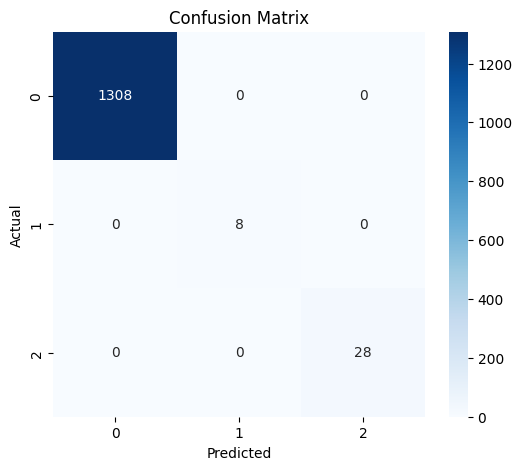

In [32]:
# Assuming X and Y are already defined as features and labels
Trainall = True
PipelineObject = True
shapValues = True

# Splitting the dataset
if Trainall:
    X_train, Y_train = X, Y
else:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    print(f'Training features shape: {X_train.shape}')
    print(f'Training labels shape: {Y_train.shape}')
    print(f'Testing features shape: {X_test.shape}')
    print(f'Testing labels shape: {Y_test.shape}')

# Define numerical features and preprocessing steps
numerical_features = [c for c in X_train.columns]
# num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
num = [([n], [SimpleImputer()]) for n in numerical_features]
mapper = DataFrameMapper(num, df_out=True)

# Initialize the RandomForestClassifier
# model = RandomForestClassifier(n_estimators=100, random_state=42)
model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=100, random_state=42)

# Create the pipeline with preprocessing and the classifier
pipeline = Pipeline([
    ('preprocess', mapper),
    ('rf', model)
])

print(f'Total samples for training: {X_train.shape[0]}')

# Fit the model
if PipelineObject:
    print('========= PipelineObject ==========')
    pipeline.fit(X_train, Y_train)
    if Trainall:
        y_pred = pipeline.predict(X_train)
        Y_true = Y_train
    else:
        y_pred = pipeline.predict(X_test)
        Y_true = Y_test
else:
    model.fit(X_train, Y_train)
    if Trainall:
        y_pred = model.predict(X_train)
        Y_true = Y_train
    else:
        y_pred = model.predict(X_test)
        Y_true = Y_test

# Evaluation
accuracy = accuracy_score(Y_true, y_pred)
balanced_acc = balanced_accuracy_score(Y_true, y_pred)
f1 = f1_score(Y_true, y_pred, average='weighted')  # Use 'weighted' for multiclass

print(f'Accuracy: {accuracy:.4f}')
print(f'Balanced Accuracy: {balanced_acc:.4f}')
print(f'F1 Score: {f1:.4f}')
print('\nClassification Report:')
print(classification_report(Y_true, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(Y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [30]:
if shapValues:
    if Trainall:
        X_test = X_train
        Y_test = Y_train

    if PipelineObject:
        explainer = shap.Explainer(pipeline['rf'], X_train)
        shap_values = explainer(X_test)
        
        shap_values_shape = np.shape(shap_values.values)
        print(f'In your case, your SHAP values have shape {shap_values_shape}, so you have SHAP values for multiple instances ({shap_values_shape[0]} instances in this case) and multiple features ({shap_values_shape[1]} features).')
    else:
        # Create SHAP explainer
        explainer = shap.TreeExplainer(model)
        # Calculate SHAP values for the test set
        shap_values = explainer.shap_values(X_test)

        shap_values_shape = np.shape(shap_values)  
        print(f'In your case, your SHAP values have shape {shap_values_shape}, so you have SHAP values for multiple instances ({shap_values_shape[0]} instances in this case) and multiple features ({shap_values_shape[1]} features).')


In your case, your SHAP values have shape (1344, 400, 3), so you have SHAP values for multiple instances (1344 instances in this case) and multiple features (400 features).


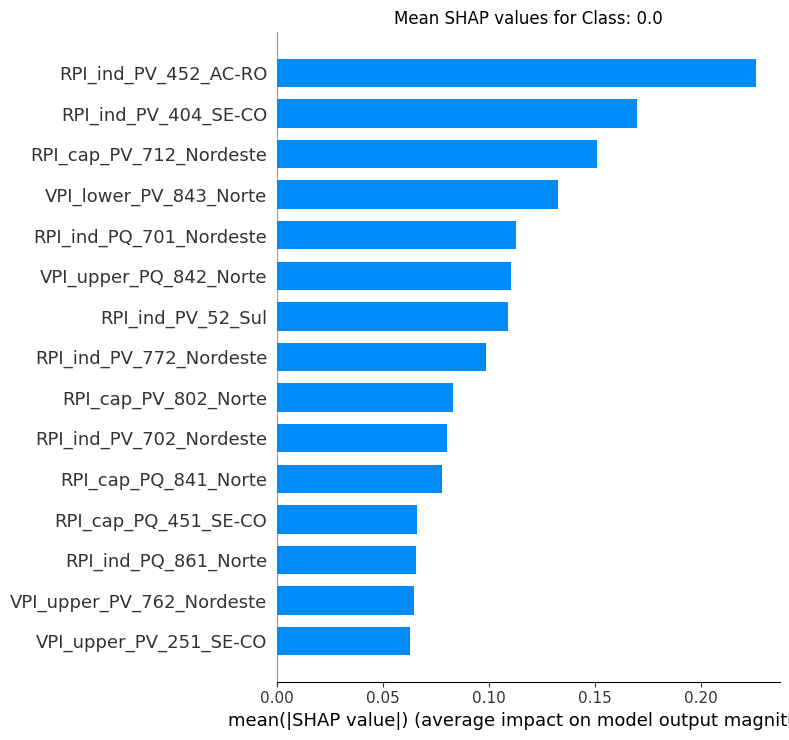

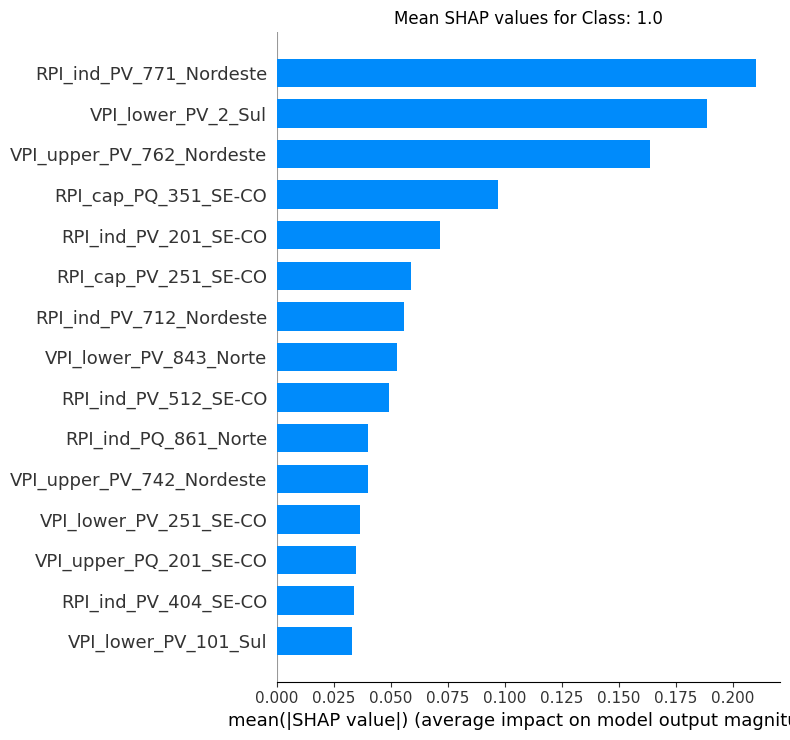

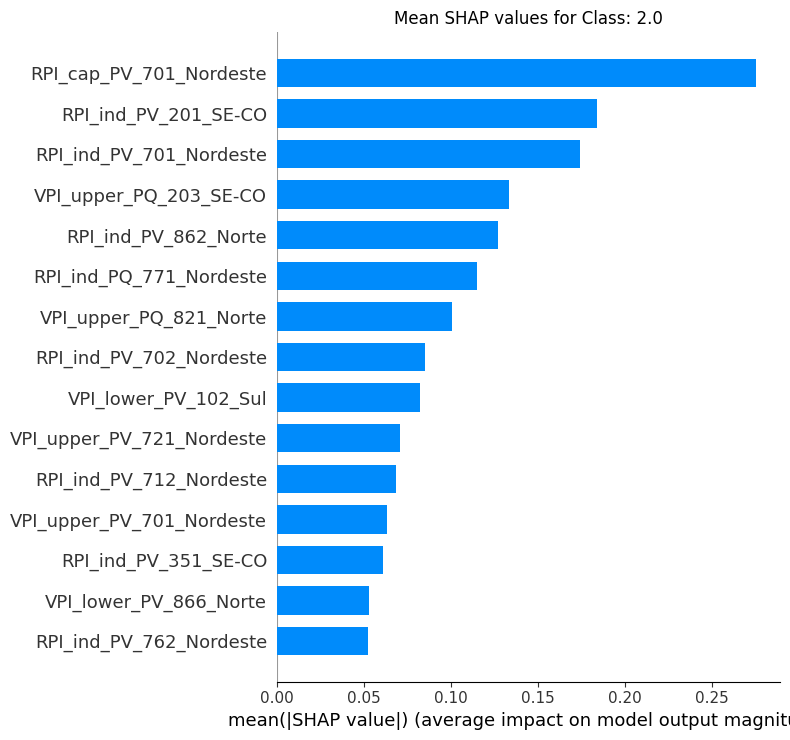

In [23]:
class_names = np.unique(Y_test)
for i, class_name in enumerate(class_names):
    plt.figure()  # Create a new figure for each class
    plt.title(f'Mean SHAP values for Class: {class_name}')  # Set the title
    shap.summary_plot(shap_values[:,:,i], X_test, plot_type="bar", max_display=15, feature_names=X_test.columns)
    plt.show()

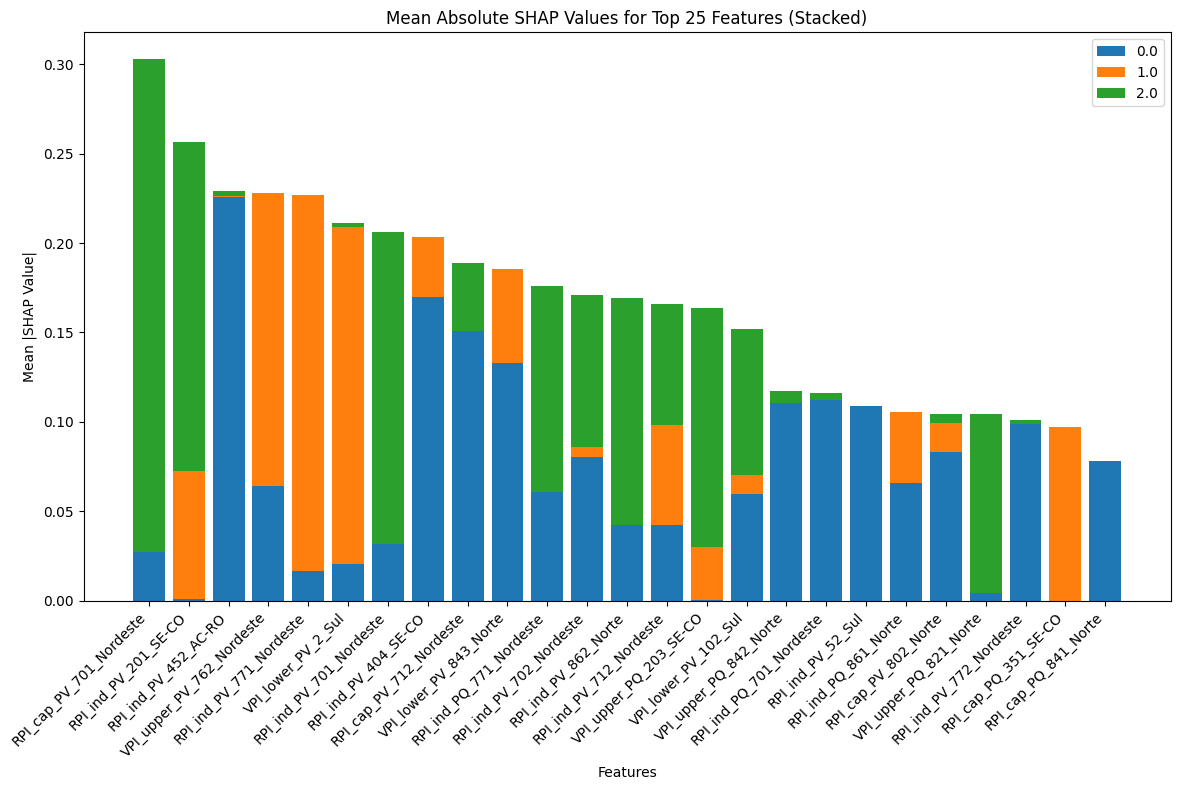

In [26]:
# Calculate mean absolute SHAP values for each feature per class
mean_shap_values_per_class = np.mean(np.abs(shap_values.values), axis=0)  # Shape: (123, 6)
# Calculate mean absolute SHAP values across all classes
mean_shap_values_agg = np.mean(mean_shap_values_per_class, axis=1)  # (123,)
# Get indices for sorting in descending order
sorted_indices = np.argsort(mean_shap_values_agg)[::-1]  # Descending order
# Get top n features and their SHAP values
n=25
top_10_features = X_test.columns[sorted_indices][:n]
top_10_shap_values = mean_shap_values_per_class[sorted_indices][:n, :]
# Plot stacked bar chart for top 10 features
plt.figure(figsize=(12, 8))
bottom = np.zeros(len(top_10_features))
for i, class_name in enumerate(class_names):
    plt.bar(
        top_10_features,
        top_10_shap_values[:, i],
        bottom=bottom,
        label=class_name,
    )
    bottom += top_10_shap_values[:, i]
# Add labels, title, and legend
plt.title(f'Mean Absolute SHAP Values for Top {n} Features (Stacked)')
plt.xlabel('Features')
plt.ylabel('Mean |SHAP Value|')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

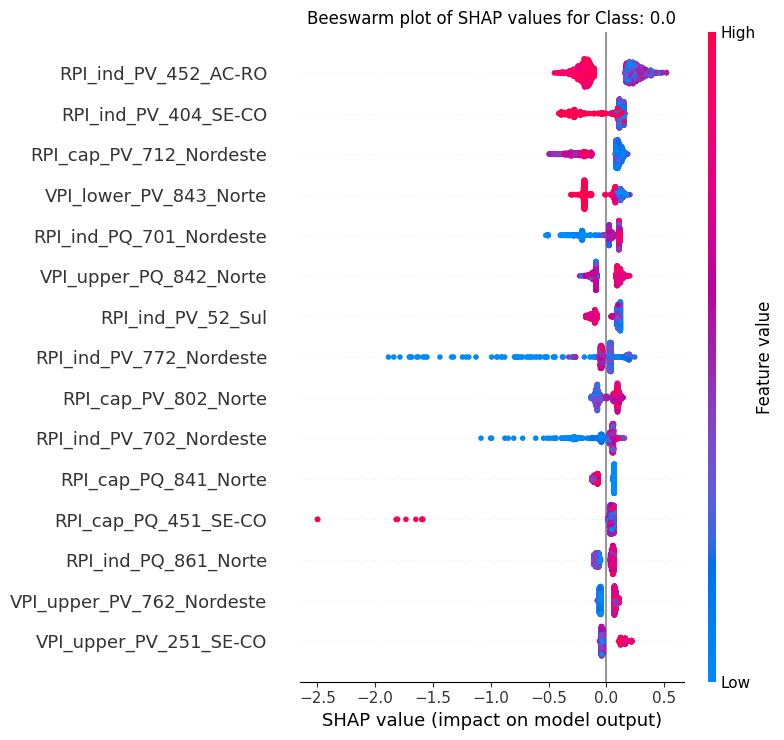

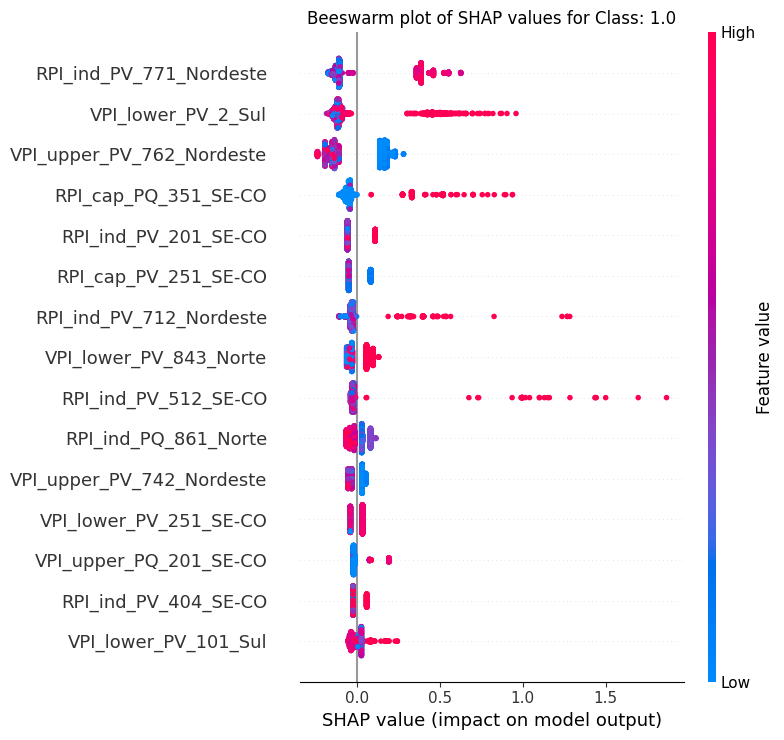

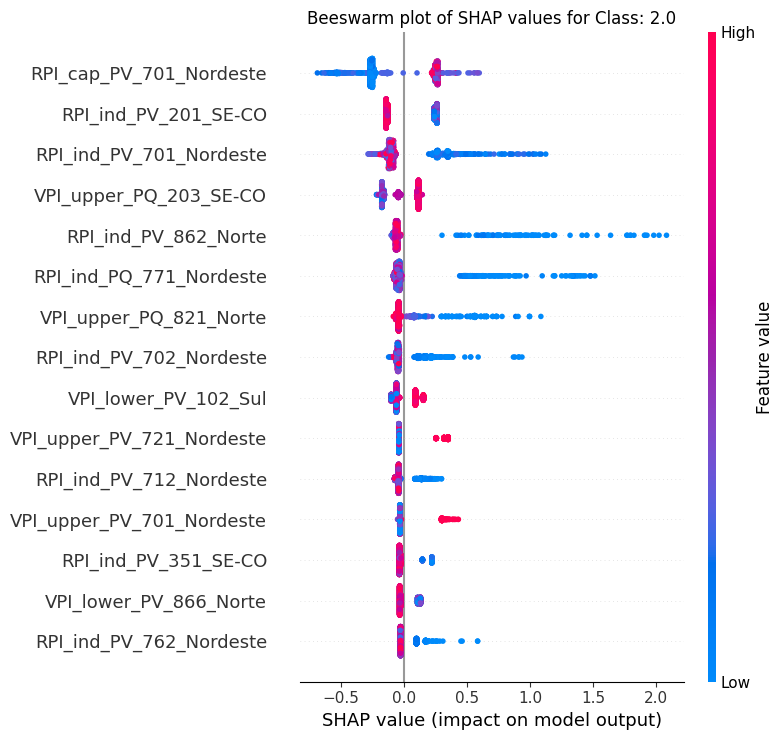

In [25]:
class_names = np.unique(Y_test)
for i, class_name in enumerate(class_names):
    plt.figure()  # Create a new figure for each class
    plt.title(f'Beeswarm plot of SHAP values for Class: {class_name}')
    shap.summary_plot(shap_values[:,:,i], X_test, max_display=15)
    plt.show()